In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

### Dataset: VHM Historical Data



In [2]:
df = pd.read_csv('../Datasets/1 - VHM Historical Data.csv')
df = df.dropna()

df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df = df.set_index('Date')
df = df.sort_index()

temp_data = df.reset_index()

# Format column "Price", "Open", "High", "Low"
for col in ['Price', 'Open', 'High', 'Low']:
    df[col] = df[col].str.replace(',', '').astype(float)

df = df[['Price']]
df


,Price
Date,
2019-03-01,68421.0
2019-03-04,70075.0
2019-03-05,68421.0
2019-03-06,69022.0
2019-03-07,69173.0
...,...
2024-05-27,39800.0
2024-05-28,39950.0
2024-05-29,39450.0


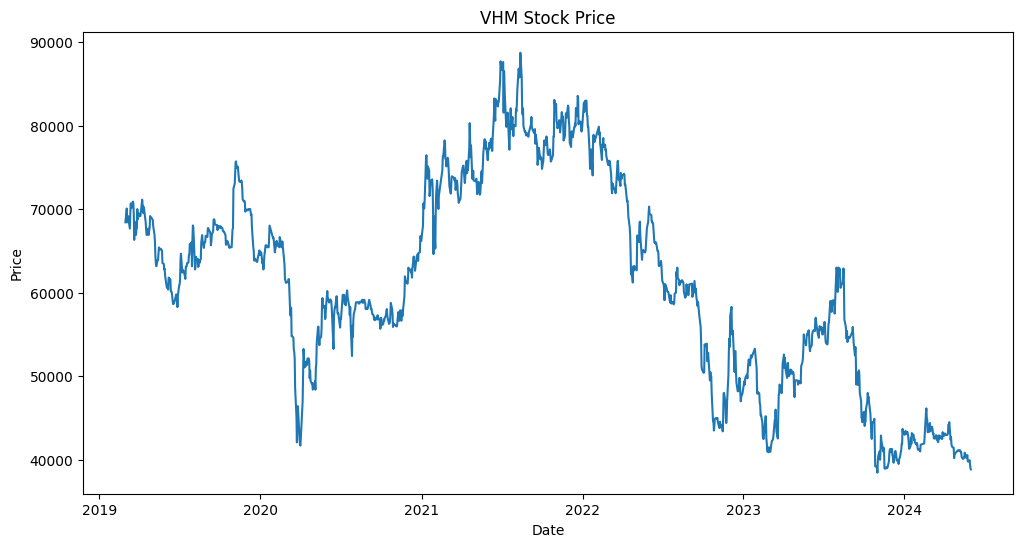

In [3]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(df['Price'])
plt.title('VHM Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

#### Ratio 7:3

In [5]:
# 4. Chia train test
train_size = round(0.7 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size]
test_data = df[train_size:]

In [6]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [9]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

d:\LearnPython\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - loss: 0.1207
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0166
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0092
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 0.0065
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.0053
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 0.0053
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 0.0048
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - loss: 0.0054
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 0.0042
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - loss: 0.0042
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 0.0041
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - loss: 0.0044
Epoch 13/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 0.0037
Epoch 14/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - loss: 0.0042
Epoch 15/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 122

In [11]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu ytest, y_pred
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
# Calculate RMSE for the testing set
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE for the testing set
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print("Testing MAPE:", test_mape)

# Calculate MAE for the testing set
test_mae = np.mean(np.abs(y_pred - ytest))
print("Testing MAE:", test_mae)

Testing RMSE: 1761.8823428983035
Testing MAPE: 3.2203590164992697
Testing MAE: 1444.0919901877135


In [14]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))


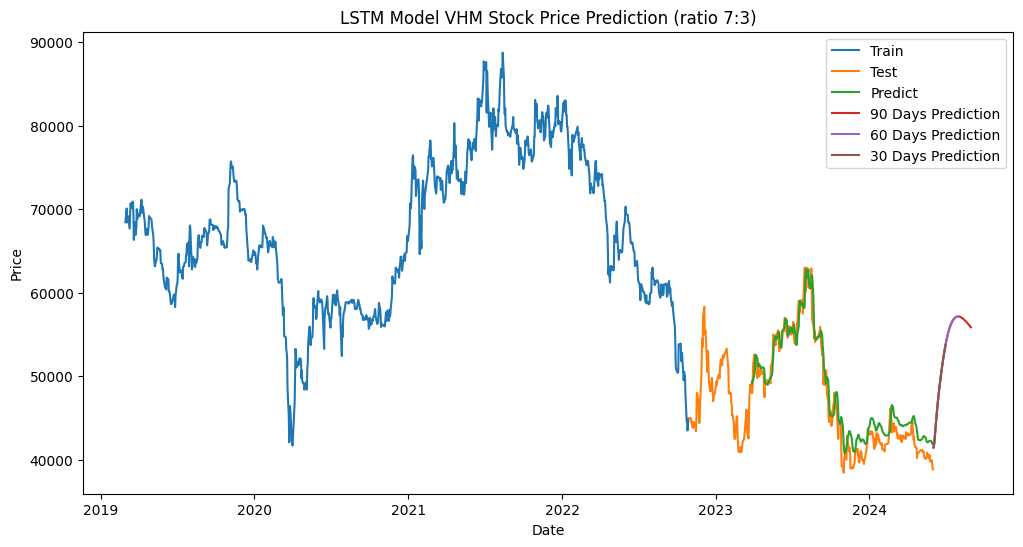

In [15]:
#14. Visualize the prediction
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('LSTM Model VHM Stock Price Prediction (ratio 7:3)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

#### Ratio 8:2

In [16]:
# 4. Chia train test
train_size = round(0.8 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size+1]
test_data = df[train_size:]

In [17]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [18]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [19]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [20]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

d:\LearnPython\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 0.1605
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0190
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0100
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0060
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0050
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0049
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0045
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0048
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0046
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0048
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0041
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0042
Epoch 13/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0043
Epoch 14/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0041
Epoch 15/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - lo

In [22]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


In [23]:
# 11. Chuẩn hóa dữ liệu ytest, y_pred
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred.reshape(-1,1))

In [24]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
# Calculate RMSE for the testing set
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE for the testing set
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print("Testing MAPE:", test_mape)

# Calculate MAE for the testing set
test_mae = np.mean(np.abs(y_pred - ytest))
print("Testing MAE:", test_mae)

Testing RMSE: 1750.6741590819468
Testing MAPE: 3.602081479246163
Testing MAE: 1497.943359375


In [25]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))


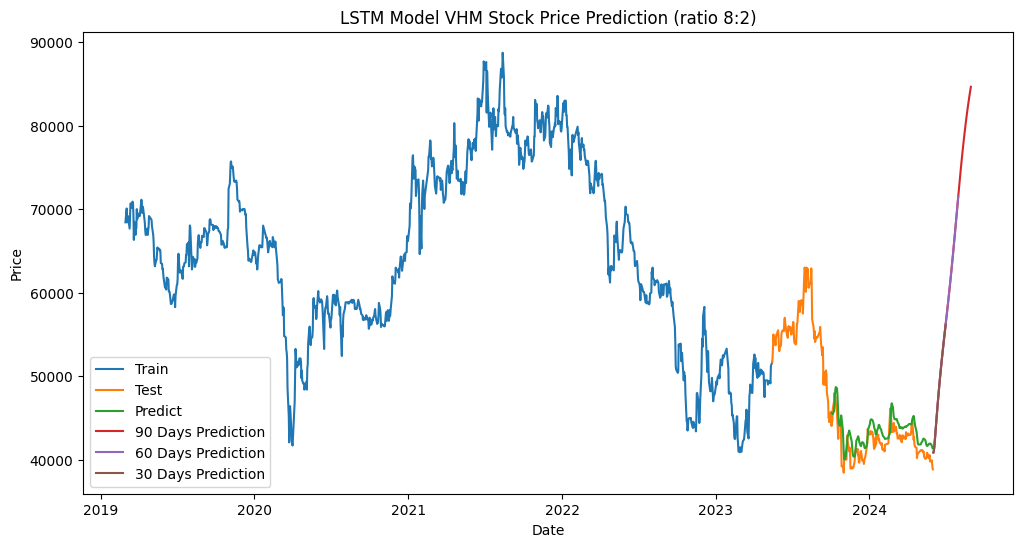

In [26]:
#14. Visualize the prediction
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size+1], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('LSTM Model VHM Stock Price Prediction (ratio 8:2)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

#### Radio 9:1

In [27]:
# 4. Chia train test
train_size = round(0.9 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size+1]
test_data = df[train_size:]

In [28]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [29]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [30]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [31]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

d:\LearnPython\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [32]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 0.1266
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0135
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0079
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0056
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0049
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0046
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0042
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - loss: 0.0045
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.0043
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 0.0040
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 0.0040
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0035
Epoch 13/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0038
Epoch 14/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0036
Epoch 15/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/ste

In [33]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 908ms/step


In [34]:
# 11. Chuẩn hóa dữ liệu ytest, y_pred
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [35]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
# Calculate RMSE for the testing set
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE for the testing set
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print("Testing MAPE:", test_mape)

# Calculate MAE for the testing set
test_mae = np.mean(np.abs(y_pred - ytest))
print("Testing MAE:", test_mae)

Testing RMSE: 1203.3773659175888
Testing MAPE: 2.688105895340758
Testing MAE: 1093.501953125


In [36]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))


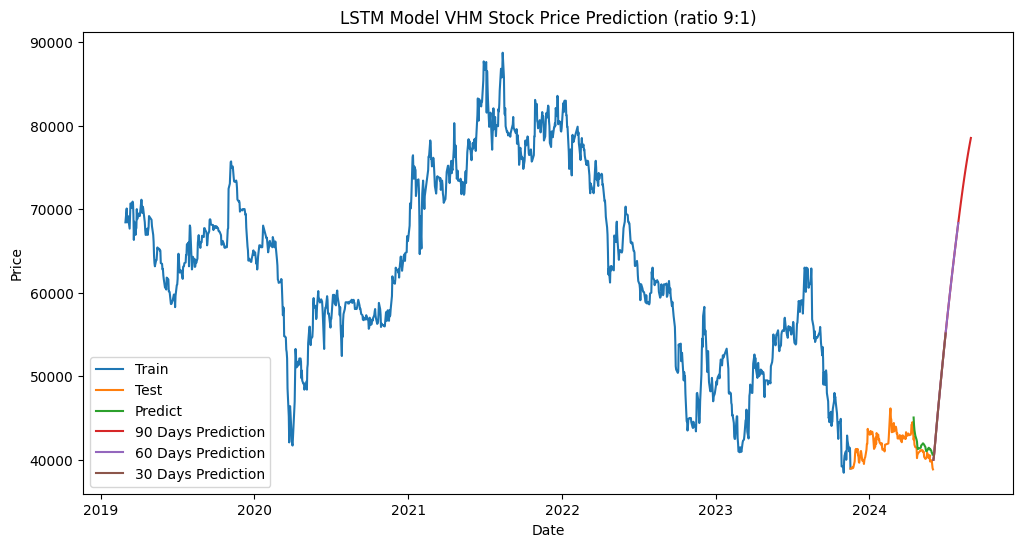

In [37]:
#14. Visualize the prediction
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size+1], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('LSTM Model VHM Stock Price Prediction (ratio 9:1)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

### Dataset: NVL Historical Data


In [38]:
df = pd.read_csv('../Datasets/2 - NVL Historical Data.csv')
df = df.dropna()

df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df = df.set_index('Date')
df = df.sort_index()

temp_data = df.reset_index()

# Format column "Price", "Open", "High", "Low"
for col in ['Price', 'Open', 'High', 'Low']:
    df[col] = df[col].str.replace(',', '').astype(float)

df = df[['Price']]
df


,Price
Date,
2019-03-01,32933.0
2019-03-04,33100.0
2019-03-05,32711.0
2019-03-06,31709.0
2019-03-07,31932.0
...,...
2024-05-27,14500.0
2024-05-28,14500.0
2024-05-29,14150.0


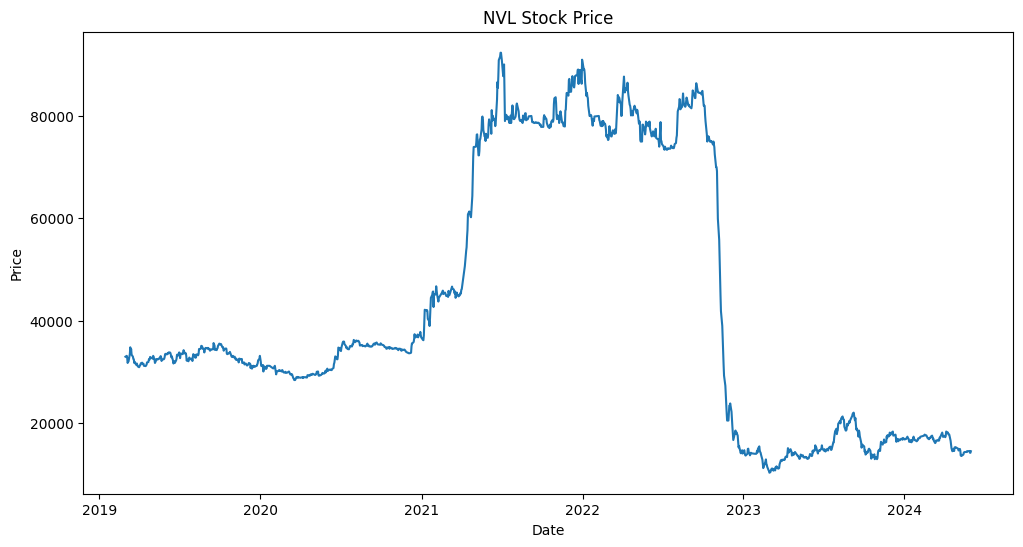

In [39]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(df['Price'])
plt.title('NVL Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [40]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

#### Ratio 7:3

In [41]:
# 4. Chia train test
train_size = round(0.7 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size + 1]
test_data = df[train_size:]

In [42]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [43]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [44]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [45]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

d:\LearnPython\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [46]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - loss: 0.2060
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0205
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0094
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0032
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0019
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0019
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0019
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0016
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0016
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0016
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0016
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0016
Epoch 13/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 0.0014
Epoch 14/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.0016
Epoch 15/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step -

In [47]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


In [48]:
# 11. Chuẩn hóa dữ liệu ytest, y_pred
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [49]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
# Calculate RMSE for the testing set
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE for the testing set
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print("Testing MAPE:", test_mape)

# Calculate MAE for the testing set
test_mae = np.mean(np.abs(y_pred - ytest))
print("Testing MAE:", test_mae)

Testing RMSE: 3027.8591771977326
Testing MAPE: 17.78376582737418
Testing MAE: 2817.122773570819


In [50]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))


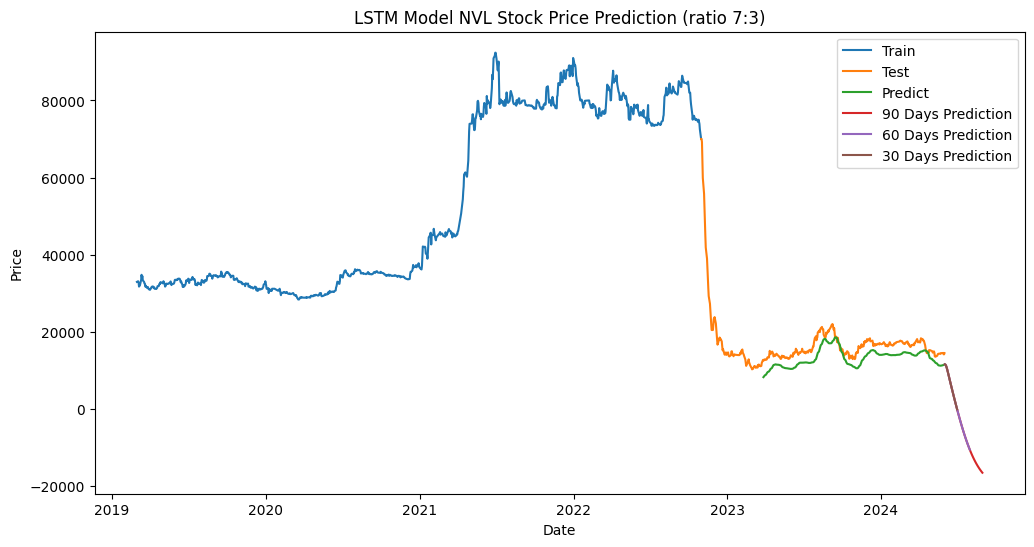

In [51]:
#14. Visualize the prediction
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size+1], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('LSTM Model NVL Stock Price Prediction (ratio 7:3)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

#### Ratio 8:2

In [52]:
# 4. Chia train test
train_size = round(0.8 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size]
test_data = df[train_size:]

In [53]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [54]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [55]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [56]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

d:\LearnPython\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [57]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.1949
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0221
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0075
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0050
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0033
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0032
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0032
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0030
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0033
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0029
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0023
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0027
Epoch 13/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0017
Epoch 14/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0017
Epoch 15/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - lo

In [58]:
# 10. Dự báo dữ liệu test, val
y_pred=model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


In [59]:
# 11. Chuẩn hóa dữ liệu ytest, y_pred
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [60]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
# Calculate RMSE for the testing set
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE for the testing set
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print("Testing MAPE:", test_mape)

# Calculate MAE for the testing set
test_mae = np.mean(np.abs(y_pred - ytest))
print("Testing MAE:", test_mae)

Testing RMSE: 801.7251488590498
Testing MAPE: 3.7944088510107234
Testing MAE: 591.0859676408179


In [61]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))


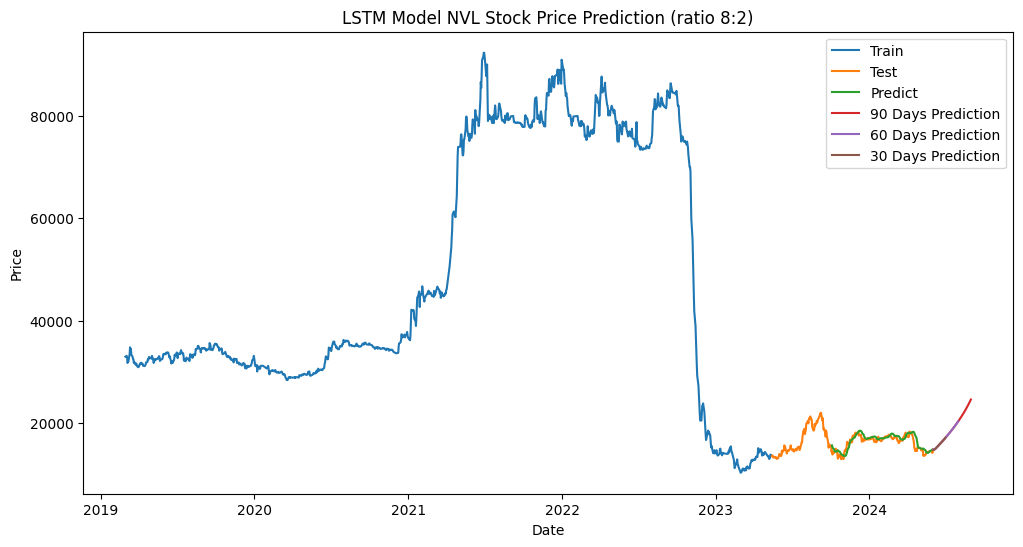

In [62]:
#14. Visualize the prediction
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('LSTM Model NVL Stock Price Prediction (ratio 8:2)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

#### Radio 9:1

In [63]:
# 4. Chia train test
train_size = round(0.9 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size]
test_data = df[train_size:]

In [64]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [65]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [66]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [67]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

d:\LearnPython\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [68]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.1051
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0091
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0050
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0037
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0033
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0030
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0024
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0020
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0019
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0015
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0016
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0016
Epoch 13/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0017
Epoch 14/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0014
Epoch 15/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - lo

In [69]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step


In [70]:
# 11. Chuẩn hóa dữ liệu ytest, y_pred
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [71]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
# Calculate RMSE for the testing set
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE for the testing set
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print("Testing MAPE:", test_mape)

# Calculate MAE for the testing set
test_mae = np.mean(np.abs(y_pred - ytest))
print("Testing MAE:", test_mae)

Testing RMSE: 998.054261781888
Testing MAPE: 4.726597621170012
Testing MAE: 691.32822265625


In [72]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

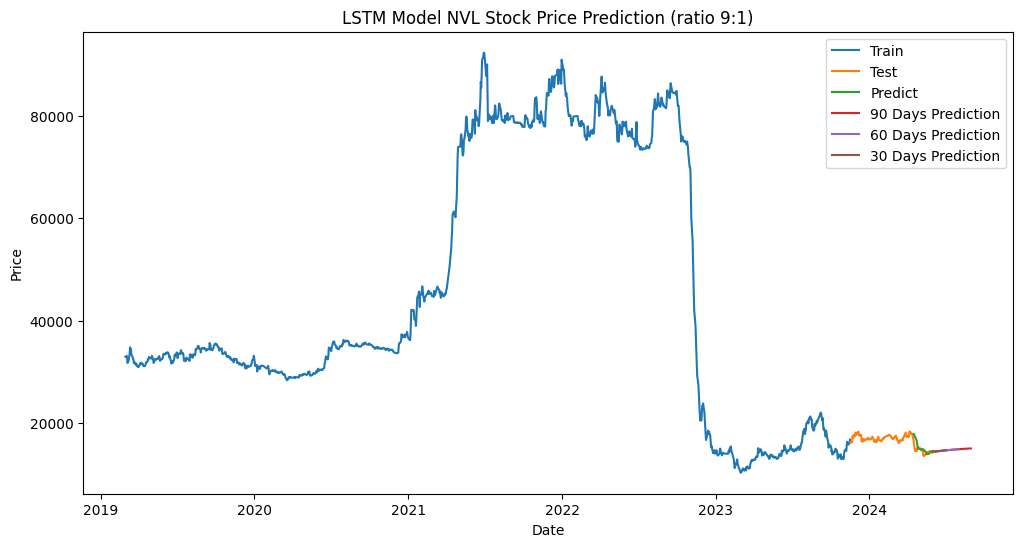

In [73]:
#14. Visualize the prediction
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('LSTM Model NVL Stock Price Prediction (ratio 9:1)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

### Dataset: NLG Historical Data


In [74]:
df = pd.read_csv('../Datasets/3 - NLG Historical Data.csv')
df = df.dropna()

df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df = df.set_index('Date')
df = df.sort_index()

temp_data = df.reset_index()

# Format column "Price", "Open", "High", "Low"
for col in ['Price', 'Open', 'High', 'Low']:
    df[col] = df[col].str.replace(',', '').astype(float)

df = df[['Price']]
df

,Price
Date,
2019-03-01,18706.8
2019-03-04,19127.2
2019-03-05,18917.0
2019-03-06,18846.9
2019-03-07,18706.8
...,...
2024-05-27,43900.0
2024-05-28,43701.0
2024-05-29,44400.0


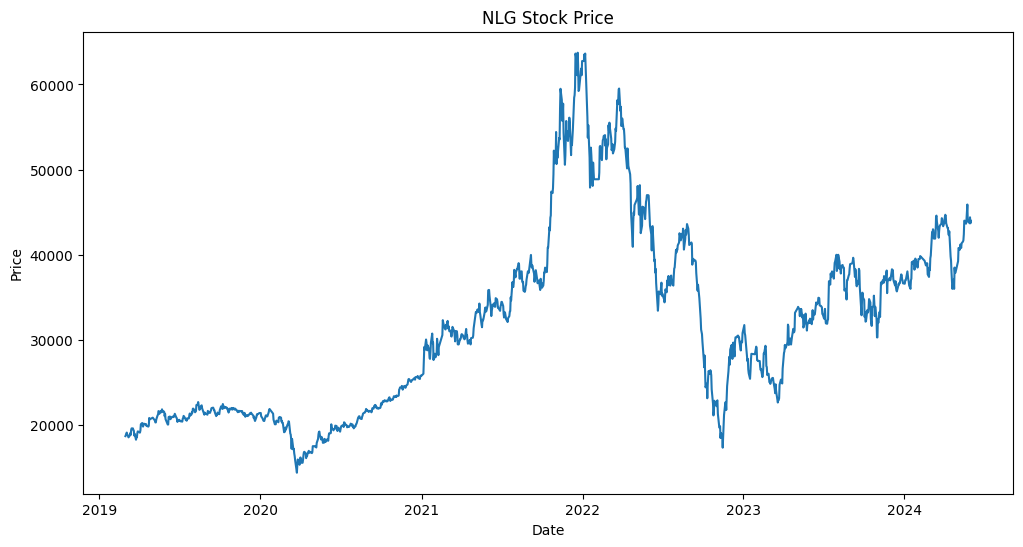

In [75]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(df['Price'])
plt.title('NLG Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [76]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

#### Ratio 7:3

In [77]:
# 4. Chia train test
train_size = round(0.7 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size]
test_data = df[train_size:]

In [78]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [79]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [80]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [81]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

d:\LearnPython\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [82]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - loss: 0.0909
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - loss: 0.0157
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 0.0062
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - loss: 0.0040
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - loss: 0.0039
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - loss: 0.0035
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - loss: 0.0033
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - loss: 0.0028
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - loss: 0.0027
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - loss: 0.0027
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - loss: 0.0028
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - loss: 0.0026
Epoch 13/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - loss: 0.0025
Epoch 14/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - loss: 0.0021
Epoch 15/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [83]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step


In [84]:
# 11. Chuẩn hóa dữ liệu ytest, y_pred
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [85]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
# Calculate RMSE for the testing set
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE for the testing set
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print("Testing MAPE:", test_mape)

# Calculate MAE for the testing set
test_mae = np.mean(np.abs(y_pred - ytest))
print("Testing MAE:", test_mae)

Testing RMSE: 1268.260479193695
Testing MAPE: 2.723513667452401
Testing MAE: 975.2692712777304


In [86]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

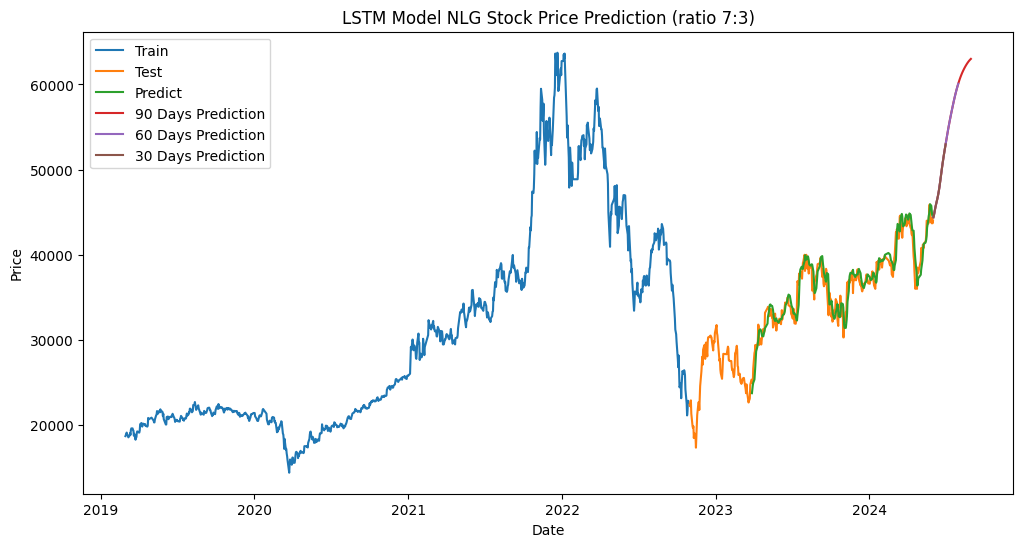

In [87]:
#14. Visualize the prediction
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('LSTM Model NLG Stock Price Prediction (ratio 7:3)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

#### Ratio 8:2

In [88]:
# 4. Chia train test
train_size = round(0.8 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size]
test_data = df[train_size:]

In [89]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [90]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [91]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [92]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

d:\LearnPython\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [93]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - loss: 0.0827
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - loss: 0.0106
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - loss: 0.0048
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - loss: 0.0041
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - loss: 0.0039
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - loss: 0.0033
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - loss: 0.0031
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - loss: 0.0026
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - loss: 0.0024
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - loss: 0.0026
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - loss: 0.0025
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - loss: 0.0023
Epoch 13/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - loss: 0.0019
Epoch 14/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - loss: 0.0019
Epoch 15/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [94]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step


In [95]:
# 11. Chuẩn hóa dữ liệu ytest, y_pred
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [96]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
# Calculate RMSE for the testing set
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE for the testing set
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print("Testing MAPE:", test_mape)

# Calculate MAE for the testing set
test_mae = np.mean(np.abs(y_pred - ytest))
print("Testing MAE:", test_mae)

Testing RMSE: 1191.030376205502
Testing MAPE: 2.469744804551563
Testing MAE: 937.8729745370371


In [97]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))


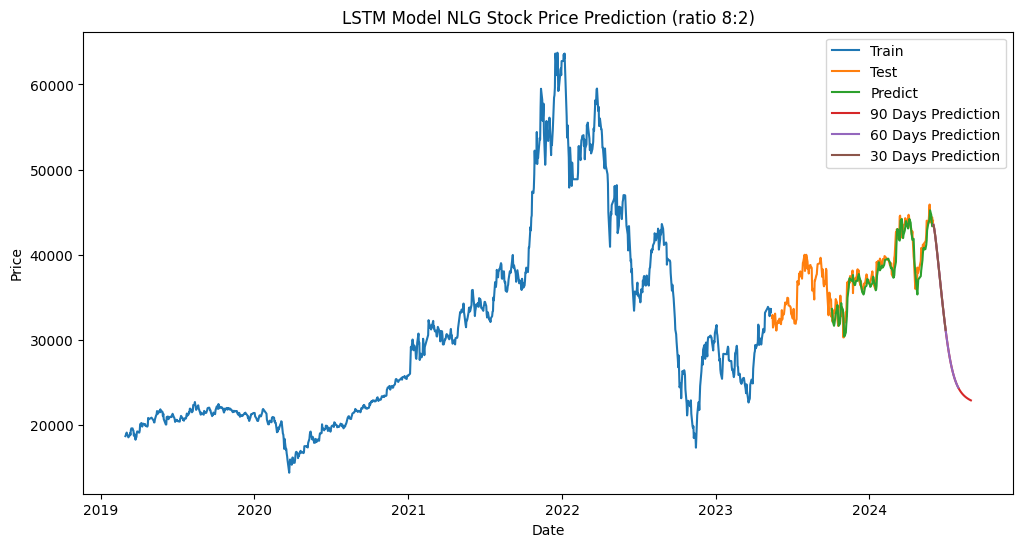

In [98]:
#14. Visualize the prediction
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('LSTM Model NLG Stock Price Prediction (ratio 8:2)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

#### Radio 9:1

In [99]:
# 4. Chia train test
train_size = round(0.9 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size]
test_data = df[train_size:]

In [100]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [101]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [102]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [103]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

d:\LearnPython\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [104]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - loss: 0.0685
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - loss: 0.0113
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - loss: 0.0052
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - loss: 0.0038
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - loss: 0.0029
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - loss: 0.0032
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - loss: 0.0030
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - loss: 0.0025
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - loss: 0.0024
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - loss: 0.0025
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - loss: 0.0020
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - loss: 0.0021
Epoch 13/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - loss: 0.0018
Epoch 14/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - loss: 0.0020
Epoch 15/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 

In [105]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [106]:
# 11. Chuẩn hóa dữ liệu ytest, y_pred
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [107]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
# Calculate RMSE for the testing set
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE for the testing set
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print("Testing MAPE:", test_mape)

# Calculate MAE for the testing set
test_mae = np.mean(np.abs(y_pred - ytest))
print("Testing MAE:", test_mae)

Testing RMSE: 1170.3581920182414
Testing MAPE: 2.1513247081618814
Testing MAE: 870.402734375


In [108]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))


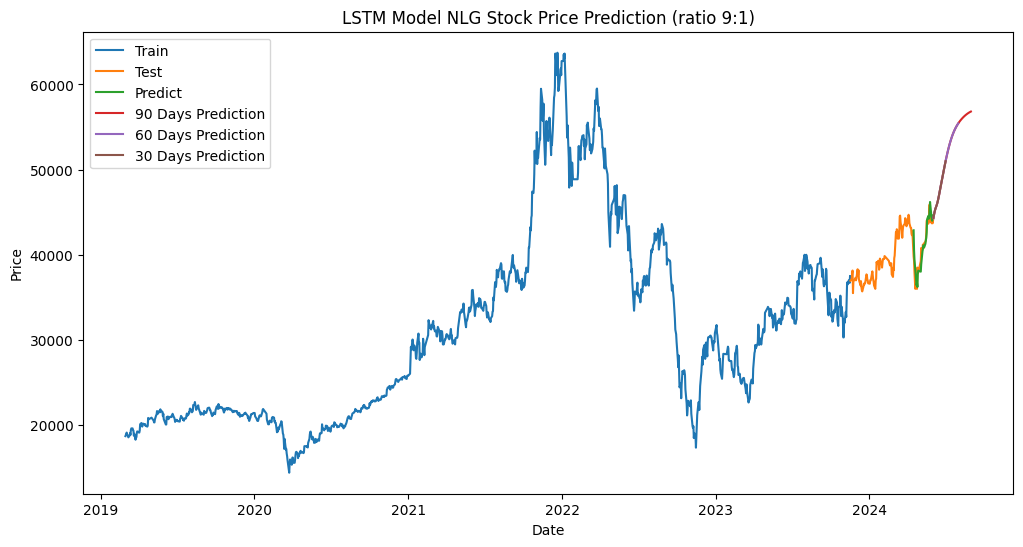

In [109]:
#14. Visualize the prediction
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('LSTM Model NLG Stock Price Prediction (ratio 9:1)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()